In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cp -av /gdrive/My\ Drive/Учеба/НИР,\ Антонов\ Андрей,\ J4133c/Experiments/results/ results/
%mkdir data
%cp -av /gdrive/My\ Drive/Учеба/НИР,\ Антонов\ Андрей,\ J4133c/Experiments/data/raw/ data/
%cp -av /gdrive/My\ Drive/Учеба/НИР,\ Антонов\ Андрей,\ J4133c/Experiments/utils/ utils/

'/gdrive/My Drive/Учеба/НИР, Антонов Андрей, J4133c/Experiments/results/' -> 'results/results'
'/gdrive/My Drive/Учеба/НИР, Антонов Андрей, J4133c/Experiments/results/cabam' -> 'results/results/cabam'
'/gdrive/My Drive/Учеба/НИР, Антонов Андрей, J4133c/Experiments/results/cabam/citeseer' -> 'results/results/cabam/citeseer'
'/gdrive/My Drive/Учеба/НИР, Антонов Андрей, J4133c/Experiments/results/cabam/citeseer/G.csv' -> 'results/results/cabam/citeseer/G.csv'
'/gdrive/My Drive/Учеба/НИР, Антонов Андрей, J4133c/Experiments/results/cabam/citeseer/Features.csv' -> 'results/results/cabam/citeseer/Features.csv'
'/gdrive/My Drive/Учеба/НИР, Антонов Андрей, J4133c/Experiments/results/cabam/polblogs' -> 'results/results/cabam/polblogs'
'/gdrive/My Drive/Учеба/НИР, Антонов Андрей, J4133c/Experiments/results/cabam/polblogs/G.csv' -> 'results/results/cabam/polblogs/G.csv'
'/gdrive/My Drive/Учеба/НИР, Антонов Андрей, J4133c/Experiments/results/cabam/polblogs/Features.csv' -> 'results/results/cabam/po

In [27]:
!pip install python-igraph
!pip install pathlib2

In [4]:
import os
from glob import glob
from pathlib import Path
import pandas as pd

import numpy as np
import collections
import matplotlib.pyplot as plt
import scipy.sparse as sp

import networkx as nx
import igraph as ig

from utils import project_utils as p_utils

In [6]:
def load_data(file_name):
    with np.load(file_name, allow_pickle=True) as loader:
        S = sp.csr_matrix((loader['adj_data'], loader['adj_indices'],
                                              loader['adj_indptr']), shape=loader['adj_shape'])

        if 'attr_data' in loader:
            X = sp.csr_matrix((loader['attr_data'], loader['attr_indices'],
                                                   loader['attr_indptr']), shape=loader['attr_shape'])
        else:
            X = None

        Label = loader.get('labels')

    return S,X,Label

In [7]:
def parse_features(feature_path):
    features_file = open(feature_path, 'r')
    features = features_file.readlines()
    features_parsed = []

    for line in features:
        itm_features = []
        for itm in line.split(','):
            try:
               itm_features.append(float(itm))
            except: pass
        
        features_parsed.append(itm_features)

    features_file.close()
    return features_parsed

In [8]:
def adj_list_to_matrix(adj_list):
    n = len(adj_list)
    adj_matrix = np.nan * np.ones((n,n))
    np.fill_diagonal(adj_matrix,0)

    for i in range(n):
        for j in adj_list[i]:
            adj_matrix[i][j] = 1
    return adj_matrix

In [9]:
result_directory = '/content/results/'
original_data_directory = '/content/data/raw/'

In [10]:
methods = [
           'real-world', 
           'acMark', 
           #'cabam', 
           'mag'
           ]
datasets = [
            'citeseer', 
            #'cora', 
            'cora_ml', 
            'polblogs', 
            #'pubmed'
            ]

GRAPHS = {}

for method in methods: GRAPHS[method] = {}

In [11]:
# Loading original networks and features
for n in datasets:
    file_path = original_data_directory + n + '.npz'
    S,X,_ = load_data(file_path)

    print(f'Loading graph and features for {n} dataset')

    GRAPHS['real-world'][n] = {
        'nx': nx.convert_matrix.from_scipy_sparse_matrix(S),
        'ig': ig.Graph.Adjacency(S.toarray().tolist()),
        'features': X.toarray()
    }

    print('Loaded successfuly\n')


Loading graph and features for citeseer dataset
Loaded successfuly

Loading graph and features for cora_ml dataset
Loaded successfuly

Loading graph and features for polblogs dataset
Loaded successfuly



In [13]:
# Loading generated networks and features
for method in methods:
  if method == 'real-world': continue
  for dataset in datasets:
    results_path = result_directory + method + '/' + dataset + '/'
    if not Path(results_path + 'G.csv').is_file(): continue 
    print(f'Loading graph and features generated by {method} from {dataset} dataset')

    df = pd.read_csv(results_path + 'G.csv', comment='#', header=None)
    GRAPHS[method][dataset] = {
        'nx': nx.readwrite.adjlist.read_adjlist(results_path + 'G.csv'),
        'ig': ig.Graph.Adjacency(adj_list_to_matrix(
            [list( map(int,i) ) for i in [lst[0].split(' ')[1:] for lst in df.values]]
        )),
        'features': parse_features(results_path + 'Features.csv')
    }

    print('Loaded successfuly\n')

Loading graph and features generated by acMark from citeseer dataset
Loaded successfuly

Loading graph and features generated by acMark from cora_ml dataset
Loaded successfuly

Loading graph and features generated by acMark from polblogs dataset
Loaded successfuly

Loading graph and features generated by mag from polblogs dataset
Loaded successfuly



In [14]:
# Graph analisys

# Structural features
print('Name,Method,Vertecies Count, Edge Count, Diameter, Radius, Average Path Length')

for method in methods:
    for dataset in datasets:
        if method in GRAPHS.keys():
            if dataset in GRAPHS[method].keys():
                G_nx, G_ig, features = GRAPHS[method][dataset].values()
                print(f'{dataset},{method},{G_ig.vcount()},{G_ig.ecount()},{G_ig.diameter()},{G_ig.radius()},{G_ig.average_path_length()}')
            else:
                print(f'{dataset},{method},-1,-1,-1,-1,-1')


Name,Method,Vertecies Count, Edge Count, Diameter, Radius, Average Path Length
citeseer,real-world,4230,5358,6,0.0,1.8017187360128906
cora_ml,real-world,2995,8416,29,0.0,9.387856944146966
polblogs,real-world,1490,19090,9,0.0,3.3901837252152363
citeseer,acMark,1681,2871,11,0.0,2.9101019462465247
cora_ml,acMark,2810,7684,14,0.0,4.014463127478405
polblogs,acMark,1222,15481,9,0.0,2.513776982690547
citeseer,mag,-1,-1,-1,-1,-1
cora_ml,mag,-1,-1,-1,-1,-1
polblogs,mag,10000,7659241,6,0.0,1.9724768716586003


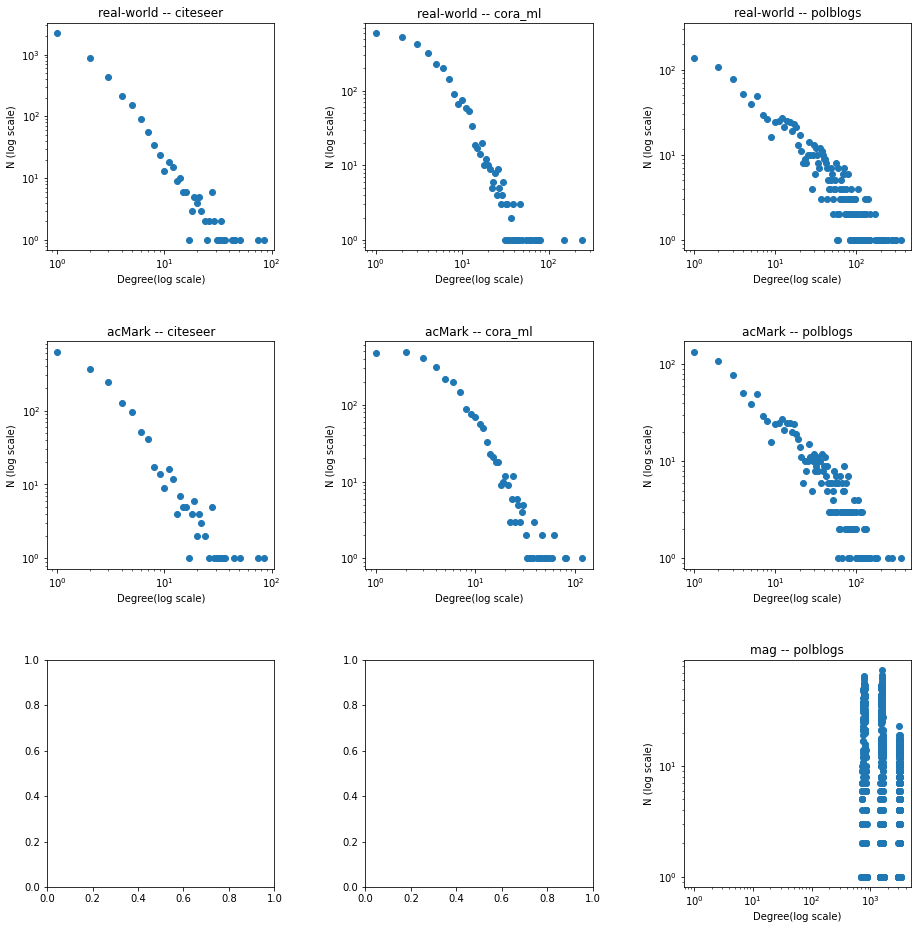

In [33]:
# Degree distribution analisys
fig, axs = plt.subplots(len(methods), len(datasets), figsize=(15,15))

for i, method in enumerate(methods):
    for j, dataset in enumerate(datasets):
        if method in GRAPHS.keys():
          if dataset in GRAPHS[method].keys():
            G = GRAPHS[method][dataset]['nx']

            aux_y = nx.degree_histogram(G)
            aux_x = np.arange(0,len(aux_y)).tolist()
            n_nodes = G.number_of_nodes()

            axs[i, j].set_title(f'{method} - {dataset}')
            axs[i, j].set_xlabel('Degree(log scale)')
            axs[i, j].set_ylabel('N (log scale)')
            axs[i, j].set_xscale('log')
            axs[i, j].set_yscale('log')

            axs[i, j].plot(aux_x, aux_y, 'o')
          else:
            pass

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
